## Processing 

In [6]:
import os
import cv2
import scipy.io as sio
import numpy as np
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras import layers, models


C:\Users\aryan\AppData\Local\Temp\ipykernel_15500\917881602.py:12: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [3]:
# Define paths
image_path = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\train_data\images"
label_path = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\train_data\ground-truth"


In [4]:
# Function to load images and annotations
def load_data(image_path, label_path, sample_index=0):
    # List image files
    image_files = sorted([f for f in os.listdir(image_path) if f.endswith('.jpg')])
    label_files = sorted([f for f in os.listdir(label_path) if f.endswith('.mat')])
    
    # Load a sample image and corresponding label
    sample_image_file = image_files[26]
    sample_label_file = label_files[26]
    
    # Load image
    image = cv2.imread(os.path.join(image_path, sample_image_file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load label (ground-truth points)
    label_data = sio.loadmat(os.path.join(label_path, sample_label_file))
    points = label_data["image_info"][0,0][0,0][0]  # Adjust according to .mat structure

    return image, points


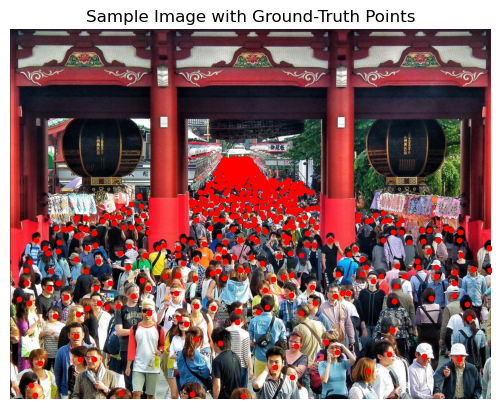

In [5]:
# Load a sample image and display it with ground-truth points
image, points = load_data(image_path, label_path, sample_index=0)

plt.imshow(image)
plt.scatter(points[:, 0], points[:, 1], s=10, color='red')  # Plot points on image
plt.title("Sample Image with Ground-Truth Points")
plt.axis('off')
plt.show()


In [6]:
def create_density_map(image_shape, points):
    density_map = np.zeros(image_shape[:2], dtype=np.float32)
    
    # Apply a Gaussian filter on each point
    for point in points:
        x, y = min(int(point[0]), image_shape[1] - 1), min(int(point[1]), image_shape[0] - 1)
        density_map[y, x] = 1

    density_map = cv2.GaussianBlur(density_map, (15, 15), 0)
    return density_map


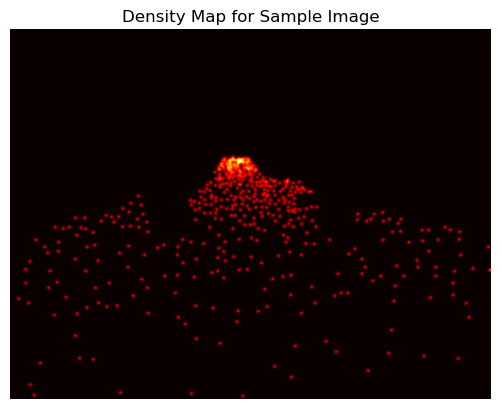

In [7]:
# Create and display density map for the sample image
density_map = create_density_map(image.shape, points)

plt.imshow(density_map, cmap='hot')
plt.axis('off')
plt.title("Density Map for Sample Image")
plt.show()


In [7]:
# Define paths
image_dir = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\train_data\images"
label_dir = r"C:\Users\aryan\Desktop\ShanghaiTech\part_A\train_data\ground-truth"


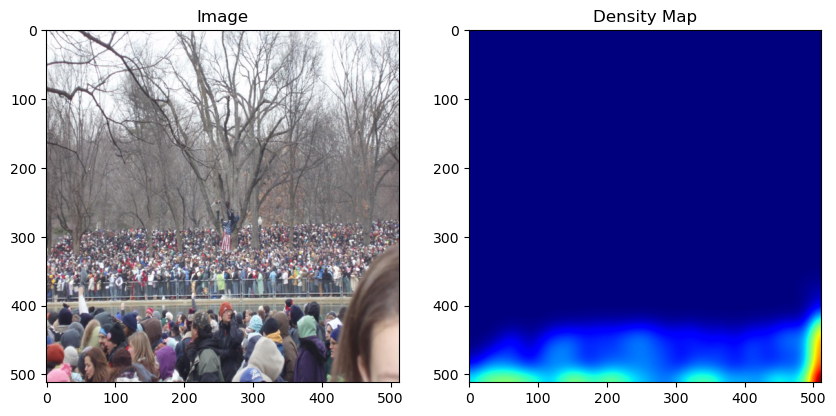

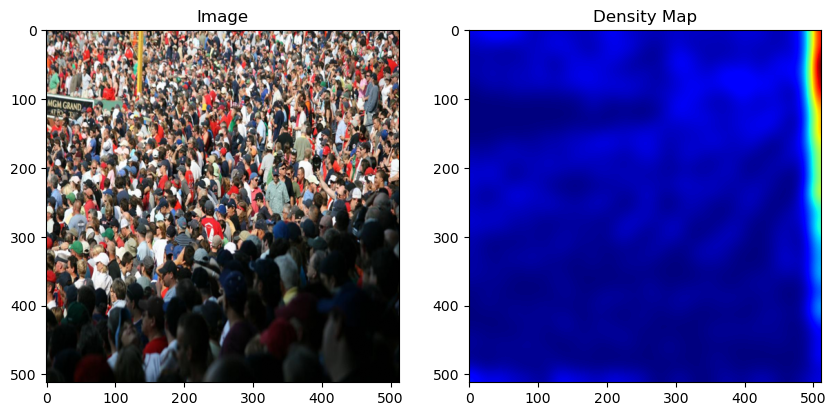

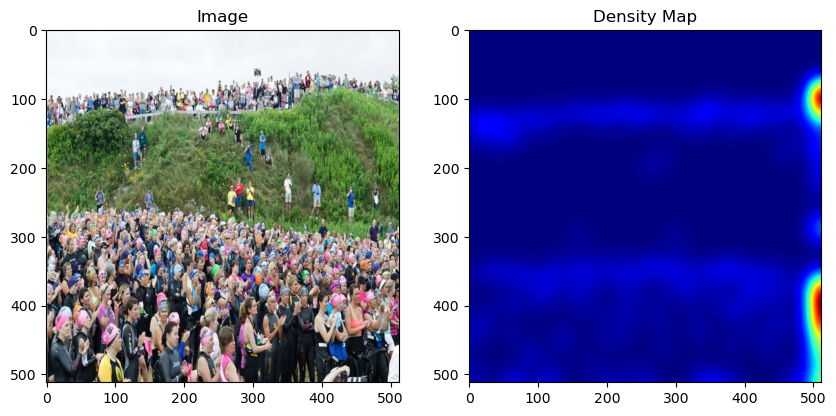

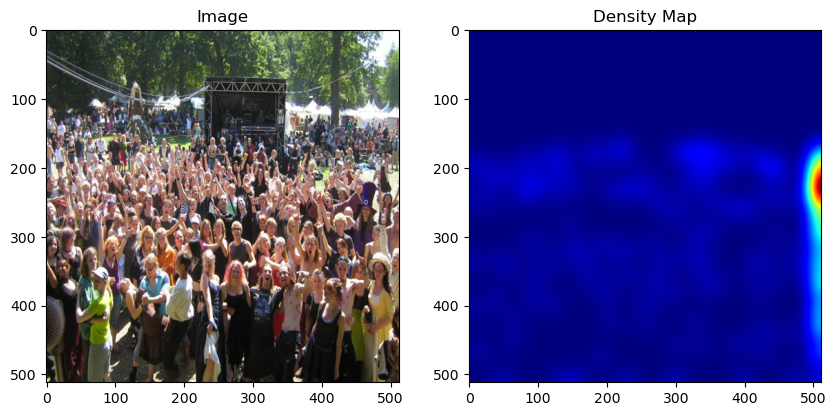

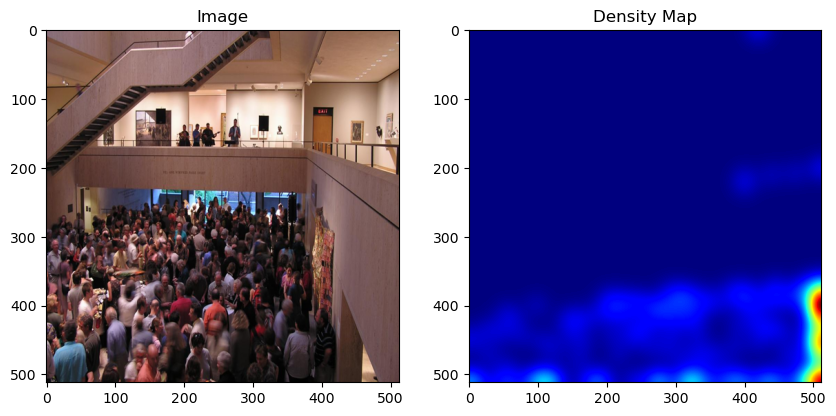

In [10]:
def preprocess_image_and_density_map(img_path, label_path, target_size=(512, 512)):
    # Load and resize image
    image = Image.open(img_path).convert('RGB')
    image = image.resize(target_size)
    image = np.array(image) / 255.0  # Normalize to [0, 1]

    # Load .mat file and create density map
    ann_points = loadmat(label_path)['image_info'][0][0][0][0][0]
    density_map = np.zeros(target_size, dtype=np.float32)

    # Generate density map from annotated points
    for point in ann_points:
        x, y = min(int(point[0] * target_size[1] / image.shape[1]), target_size[1] - 1), \
               min(int(point[1] * target_size[0] / image.shape[0]), target_size[0] - 1)
        density_map[y, x] = 1
    
    density_map = gaussian_filter(density_map, sigma=15)  # Apply Gaussian filter

    return image, density_map

# Load and preprocess a sample image and density map to check
sample_images = os.listdir(image_dir)[:5]  # Load a few sample images
for img_name in sample_images:
    img_path = os.path.join(image_dir, img_name)
    label_path = os.path.join(label_dir, f"GT_{img_name.split('.')[0]}.mat")
    img, density_map = preprocess_image_and_density_map(img_path, label_path)

    # Display the image and density map
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(density_map, cmap='jet')
    plt.title("Density Map")
    plt.show()


## Main Project

In [11]:
from pyngrok import ngrok
ngrok.set_auth_token("26wxKnARk0A70cZyNYsqXqIv7mS_7pvb9zecXTk4U2rWcXUBx")


In [12]:
public_url = ngrok.connect(5000)
print(f" * ngrok tunnel started! Access at {public_url}")


 * ngrok tunnel started! Access at NgrokTunnel: "https://15a5-103-47-74-66.ngrok-free.app" -> "http://localhost:5000"


## YOLOv8 VF 

In [4]:
import os
import threading
import cv2
import base64
import numpy as np
import random
import time
from flask import Flask, jsonify, render_template_string, request
from flask_socketio import SocketIO
from ultralytics import YOLO

# Initialize Flask and Flask-SocketIO
app = Flask(__name__)
socketio = SocketIO(app, cors_allowed_origins="*")

# Initialize the YOLO model
model = YOLO('yolov8n.pt')  # Replace with your specific YOLO model if needed
processing_flag = False
people_count = 0
bill_count = 0  # Default bill count, updated when provided by the user

# Constants for wait time calculation
wait_time_per_person = 2  # Base wait time in minutes per person
additional_time_per_bill = 1.5  # Additional time per bill in minutes
food_prep_time = 5  # Fixed time for food preparation

# Pre-assigned video paths for each section
video_paths = {
    "Southern": r"C:\Users\aryan\Desktop\2Check_1.mp4",
    "Hotspot": r"C:\Users\aryan\Desktop\3Check_1.mp4",
    "Kathi": r"C:\Users\aryan\Desktop\1Check_1.mp4"
}

@app.route('/')
def index():
    return """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Live YOLOv8 Classification</title>
        <style>
            body { 
                font-family: Arial, sans-serif; 
                display: flex; 
                flex-direction: column; 
                align-items: center; 
                padding: 20px; 
                min-height: 100vh;
                background-color: #f0f2f5;
            }
            h1 { 
                color: #333; 
                margin-bottom: 30px;
            }
            .controls { 
                display: flex; 
                flex-direction: column; 
                gap: 20px; 
                margin-top: 50px; 
                width: 100%; 
                max-width: 300px;
            }
            .controls button { 
                padding: 20px; 
                font-size: 18px; 
                color: white; 
                font-weight: bold;
                background: linear-gradient(135deg, #007bff, #0056b3);
                border: none; 
                cursor: pointer; 
                border-radius: 12px; 
                width: 100%;
                text-align: center;
                box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
                transition: background 0.3s, transform 0.2s, box-shadow 0.3s;
            }
            .controls button:hover {
                background: linear-gradient(135deg, #0056b3, #003f8a);
                transform: translateY(-2px);
                box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3);
            }
            .controls button:active {
                transform: translateY(0);
                box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
            }
        </style>
    </head>
    <body>
        <h1>Choose Outlet</h1>
        <div class="controls">
            <button onclick="startSection('Southern')">Southern</button>
            <button onclick="startSection('Hotspot')">Hotspot</button>
            <button onclick="startSection('Kathi')">Kathi</button>
        </div>
        
        <script src="https://cdn.socket.io/4.0.1/socket.io.min.js"></script>
        <script>
            const socket = io.connect("http://127.0.0.1:5000");

            function startSection(name) {
                fetch("http://127.0.0.1:5000/start_section", {
                    method: "POST",
                    headers: { "Content-Type": "application/json" },
                    body: JSON.stringify({ section: name })
                }).then(response => {
                    if (response.ok) {
                        window.location.href = "/output";  // Redirect to the output screen once the section starts
                    } else {
                        console.error("Error starting section.");
                    }
                });
            }
        </script>
    </body>
    </html>
    """


# Output page for displaying the video feed and results
@app.route('/output')
def output():
    return """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Live YOLOv8 Classification</title>
        <style>
            body { 
                font-family: Arial, sans-serif; 
                display: flex; 
                flex-direction: column; 
                align-items: center; 
                padding: 20px; 
                min-height: 100vh;
            }
            h1 { color: #333; }
            .output-container {
                display: flex;
                align-items: flex-start;
                justify-content: center;
                gap: 20px;  /* Space between video and POS box */
            }
            .output { text-align: center; }
            .output h2 { color: #333; }
            .output img { border: 2px solid #ddd; border-radius: 8px; margin-top: 10px; width: 640px; }
            .back-button { padding: 10px 15px; background-color: #f44336; color: white; border: none; cursor: pointer; border-radius: 5px; position: fixed; bottom: 20px; }
            .pos-box {
                background-color: #fff;
                padding: 15px;
                margin-top: 20px;
                border-radius: 8px;
                box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
                width: 250px;
                text-align: center;
            }
            .pos-box h3 { color: #333; margin-bottom: 10px; }
            .pos-box p { font-size: 18px; color: #007bff; font-weight: bold; }
        </style>
    </head>
    <body>
        <h1>Processing Video Frame...</h1>
        <div class="output-container">
            <div class="output">
                <h2>Processed Frame:</h2>
                <img id="videoFrame" src="" alt="Processed frame will appear here">
                <p id="peopleCount">People Count: 0</p>
            </div>
            
            <div class="pos-box">
                <h3>Simulated POS Bill Count</h3>
                <p id="billCount">Bill Count: 1</p>
                <p id="simulatedWaitTime">Estimated Wait Time: 0 minutes</p>
            </div>
        </div>

        <button class="back-button" onclick="stopProcessing()">Back to Selection</button>

        <script src="https://cdn.socket.io/4.0.1/socket.io.min.js"></script>
        <script>
            const socket = io.connect("http://127.0.0.1:5000");

            socket.on("frame", (data) => {
                document.getElementById("videoFrame").src = "data:image/jpeg;base64," + data.image;
                document.getElementById("peopleCount").innerText = "People Count: " + data.count;
            });

            socket.on("update_bill_count", (data) => {
                document.getElementById("billCount").innerText = "Bill Count: " + data.bill_count;
                document.getElementById("simulatedWaitTime").innerText = "Estimated Wait Time: " + data.wait_time + " minutes";
            });

            function stopProcessing() {
                fetch("http://127.0.0.1:5000/stop_section", {
                    method: "POST"
                }).then(response => {
                    if (response.ok) {
                        window.location.href = "/";  // Redirect back to selection page
                    } else {
                        console.error("Error stopping section.");
                    }
                });
            }
        </script>
    </body>
    </html>
    """

@app.route('/start_section', methods=['POST'])
def start_section():
    global processing_flag, bill_count
    data = request.json
    section = data.get('section')
    video_path = video_paths.get(section)
    
    # Stop the current processing if active
    processing_flag = False
    time.sleep(1)  # Give time to stop the previous thread
    
    # Reset bill count when starting a new section
    bill_count = 0
    
    # Start new video processing for the selected outlet
    if video_path and os.path.exists(video_path):
        processing_flag = True
        threading.Thread(target=process_video, args=(video_path,)).start()
        threading.Thread(target=simulate_pos_bill_count).start()
        return jsonify({"status": "success"}), 200
    return jsonify({"status": "failed"}), 400


@app.route('/stop_section', methods=['POST'])
def stop_section():
    global processing_flag
    processing_flag = False
    return jsonify({"status": "stopped"}), 200

def process_video(video_path):
    global processing_flag, people_count
    cap = cv2.VideoCapture(video_path)
    while processing_flag and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Run YOLO model and obtain bounding boxes with confidence
        results = model(frame)[0]
        annotated_frame = frame.copy()
        
        # Draw bounding boxes with confidence scores
        for r in results.boxes:
            conf = r.conf.cpu().item()
            if conf >= 0.5:
                x1, y1, x2, y2 = map(int, r.xyxy[0].tolist())
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = f"Person: {conf:.2f}"
                cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Encode frame and emit via SocketIO
        _, buffer = cv2.imencode('.jpg', annotated_frame)
        frame_encoded = base64.b64encode(buffer).decode('utf-8')
        people_count = len(results)
        socketio.emit("frame", {"image": frame_encoded, "count": people_count})

        time.sleep(0.05)  # Control frame rate

    cap.release()

def simulate_pos_bill_count():
    global bill_count
    while processing_flag:
        # Increment bill count only if it is less than or equal to the current people count
        if bill_count < people_count:
            bill_count += 1

        # Calculate wait time based on the bill count and other parameters
        wait_time = int(bill_count * additional_time_per_bill + food_prep_time)
        
        # Emit updated bill count and wait time
        socketio.emit("update_bill_count", {"bill_count": bill_count, "wait_time": wait_time})
        time.sleep(5)  # Update interval for simulated bill count



# Run Flask app
if __name__ == '__main__':
    
    socketio.run(app, host="127.0.0.1", port=5000, allow_unsafe_werkzeug=True)


Werkzeug appears to be used in a production deployment. Consider switching to a production web server instead.


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [21/Nov/2024 11:30:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:30:12] "GET /socket.io/?EIO=4&transport=polling&t=PDDJeTH HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:30:12] "POST /socket.io/?EIO=4&transport=polling&t=PDDJeZX&sid=767Rt2ZWrMAOnuUSAAAA HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:30:12] "GET /socket.io/?EIO=4&transport=polling&t=PDDJeZa&sid=767Rt2ZWrMAOnuUSAAAA HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:30:13] "GET /socket.io/?EIO=4&transport=polling&t=PDDJegB&sid=767Rt2ZWrMAOnuUSAAAA HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:30:13] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [21/Nov/2024 11:30:15] "POST /start_section HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:30:15] "GET /socket.io/?EIO=4&transport=websocket&sid=767Rt2ZWrMAOnuUSAAAA HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:30:15] "GET /output HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:30:16] "GET /socket.io/?EIO=4


0: 384x640 12 persons, 1 backpack, 231.9ms
Speed: 16.0ms preprocess, 231.9ms inference, 17.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 backpack, 126.0ms
Speed: 8.0ms preprocess, 126.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 backpack, 107.3ms
Speed: 3.0ms preprocess, 107.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 backpack, 129.7ms
Speed: 3.6ms preprocess, 129.7ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 backpack, 111.8ms
Speed: 4.0ms preprocess, 111.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 backpack, 116.1ms
Speed: 4.0ms preprocess, 116.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 backpack, 128.3ms
Speed: 3.0ms preprocess, 128.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 

127.0.0.1 - - [21/Nov/2024 11:30:26] "GET /socket.io/?EIO=4&transport=websocket&sid=jfHOP5P0eQ-dBB3aAAAC HTTP/1.1" 200 -


0: 384x640 9 persons, 2 backpacks, 238.8ms
Speed: 4.0ms preprocess, 238.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 backpacks, 2 handbags, 129.6ms
Speed: 4.0ms preprocess, 129.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 2 backpacks, 1 handbag, 119.0ms
Speed: 4.0ms preprocess, 119.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 2 backpacks, 1 handbag, 111.5ms
Speed: 4.0ms preprocess, 111.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 backpack, 1 handbag, 125.9ms
Speed: 3.0ms preprocess, 125.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 backpack, 148.0ms
Speed: 4.3ms preprocess, 148.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 164.7ms
Speed: 4.0ms preprocess, 164.7ms inference, 1.0ms postprocess per image 

## Themed 

In [ ]:
import os
import threading
import cv2
import base64
import numpy as np
import random
import time
from flask import Flask, jsonify, render_template_string, request
from flask_socketio import SocketIO
from ultralytics import YOLO

# Initialize Flask and Flask-SocketIO
app = Flask(__name__)
socketio = SocketIO(app, cors_allowed_origins="*")

# Initialize the YOLO model
model = YOLO('yolov8n.pt')  # Replace with your specific YOLO model if needed
processing_flag = False
people_count = 0
bill_count = 0  # Default bill count, updated when provided by the user

# Constants for wait time calculation
wait_time_per_person = 2  # Base wait time in minutes per person
additional_time_per_bill = 1.5  # Additional time per bill in minutes
food_prep_time = 7  # Fixed time for food preparation

# Pre-assigned video paths for each section
video_paths = {
    "Southern": r"C:\Users\aryan\Desktop\2Check_1.mp4",
    "Hotspot": r"C:\Users\aryan\Desktop\3Check_1.mp4",
    "Kathi": r"C:\Users\aryan\Desktop\1Check_1.mp4"
}

@app.route('/')
def index():
    return """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Live YOLOv8 Classification</title>
        <style>
            body { 
                font-family: Arial, sans-serif; 
                display: flex; 
                flex-direction: column; 
                align-items: center; 
                padding: 20px; 
                min-height: 100vh;
                background-color: #121212;
                color: #ffffff;
            }
            h1 { 
                color: #00adb5; 
                margin-bottom: 30px;
                font-weight: bold;
                font-size: 24px;
            }
            .controls { 
                display: flex; 
                flex-direction: column; 
                gap: 20px; 
                margin-top: 50px; 
                width: 100%; 
                max-width: 300px;
            }
            .controls button { 
                padding: 20px; 
                font-size: 18px; 
                color: white; 
                font-weight: bold;
                background-color: #393e46;
                border: none; 
                cursor: pointer; 
                border-radius: 12px; 
                width: 100%;
                text-align: center;
                box-shadow: 0 4px 10px rgba(0, 173, 181, 0.3);
                transition: background 0.3s, transform 0.2s, box-shadow 0.3s;
            }
            .controls button:hover {
                background-color: #00adb5;
                transform: translateY(-2px);
                box-shadow: 0 6px 12px rgba(0, 173, 181, 0.6);
            }
            .controls button:active {
                transform: translateY(0);
                box-shadow: 0 4px 8px rgba(0, 173, 181, 0.3);
            }
        </style>
    </head>
    <body>
        <h1>Select Outlet</h1>
        <div class="controls">
            <button onclick="startSection('Southern')">Southern</button>
            <button onclick="startSection('Hotspot')">Hotspot</button>
            <button onclick="startSection('Kathi')">Kathi</button>
        </div>
        
        <script src="https://cdn.socket.io/4.0.1/socket.io.min.js"></script>
        <script>
            const socket = io.connect("http://127.0.0.1:5000");

            function startSection(name) {
                fetch("http://127.0.0.1:5000/start_section", {
                    method: "POST",
                    headers: { "Content-Type": "application/json" },
                    body: JSON.stringify({ section: name })
                }).then(response => {
                    if (response.ok) {
                        window.location.href = "/output";  // Redirect to output screen once the section starts
                    } else {
                        console.error("Error starting section.");
                    }
                });
            }
        </script>
    </body>
    </html>
    """


@app.route('/output')
def output():
    return """
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Live YOLOv8 Classification</title>
        <style>
            body { 
                font-family: Arial, sans-serif; 
                display: flex; 
                flex-direction: column; 
                align-items: center; 
                padding: 20px; 
                min-height: 100vh;
                background-color: #121212;
                color: #ffffff;
            }
            h1 { color: #00adb5; font-weight: bold; font-size: 24px; }
            .output-container {
                display: flex;
                align-items: flex-start;
                justify-content: center;
                gap: 20px;
            }
            .output { text-align: center; }
            .output h2 { color: #00adb5; font-weight: bold; }
            .output img { 
                border: 2px solid #393e46; 
                border-radius: 8px; 
                margin-top: 10px; 
                width: 640px;
                box-shadow: 0 4px 12px rgba(0, 0, 0, 0.3);
            }
            .back-button { 
                padding: 10px 15px; 
                background-color: #ff5722; 
                color: white; 
                border: none; 
                cursor: pointer; 
                border-radius: 5px; 
                position: fixed; 
                bottom: 20px;
                font-weight: bold;
                box-shadow: 0 4px 10px rgba(255, 87, 34, 0.3);
                transition: background 0.3s;
            }
            .back-button:hover {
                background-color: #e64a19;
            }
            .pos-box {
                background-color: #1f1f1f;
                padding: 15px;
                margin-top: 20px;
                border-radius: 8px;
                box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);
                width: 250px;
                text-align: center;
            }
            .pos-box h3 { color: #00adb5; margin-bottom: 10px; font-weight: bold; }
            .pos-box p { font-size: 18px; color: #00adb5; font-weight: bold; }
        </style>
    </head>
    <body>
        <h1>Processing Video Frame...</h1>
        <div class="output-container">
            <div class="output">
                <h2>Processed Frame:</h2>
                <img id="videoFrame" src="" alt="Processed frame will appear here">
                <p id="peopleCount">People Count: 0</p>
            </div>
            
            <div class="pos-box">
                <h3>Simulated POS Bill Count</h3>
                <p id="billCount">Bill Count: 1</p>
                <p id="simulatedWaitTime">Estimated Wait Time: 0 minutes</p>
            </div>
        </div>

        <button class="back-button" onclick="stopProcessing()">Back to Selection</button>

        <script src="https://cdn.socket.io/4.0.1/socket.io.min.js"></script>
        <script>
            const socket = io.connect("http://127.0.0.1:5000");

            socket.on("frame", (data) => {
                document.getElementById("videoFrame").src = "data:image/jpeg;base64," + data.image;
                document.getElementById("peopleCount").innerText = "People Count: " + data.count;
            });

            socket.on("update_bill_count", (data) => {
                document.getElementById("billCount").innerText = "Bill Count: " + data.bill_count;
                document.getElementById("simulatedWaitTime").innerText = "Estimated Wait Time: " + data.wait_time + " minutes";
            });

            function stopProcessing() {
                fetch("http://127.0.0.1:5000/stop_section", {
                    method: "POST"
                }).then(response => {
                    if (response.ok) {
                        window.location.href = "/";  // Redirect back to selection page
                    } else {
                        console.error("Error stopping section.");
                    }
                });
            }
        </script>
    </body>
    </html>
    """



@app.route('/start_section', methods=['POST'])
def start_section():
    global processing_flag, bill_count
    data = request.json
    section = data.get('section')
    video_path = video_paths.get(section)
    
    # Stop the current processing if active
    processing_flag = False
    time.sleep(1)  # Give time to stop the previous thread
    
    # Reset bill count when starting a new section
    bill_count = 1
    
    # Start new video processing for the selected outlet
    if video_path and os.path.exists(video_path):
        processing_flag = True
        threading.Thread(target=process_video, args=(video_path,)).start()
        threading.Thread(target=simulate_pos_bill_count).start()
        return jsonify({"status": "success"}), 200
    return jsonify({"status": "failed"}), 400


@app.route('/stop_section', methods=['POST'])
def stop_section():
    global processing_flag
    processing_flag = False
    return jsonify({"status": "stopped"}), 200

def process_video(video_path):
    global processing_flag, people_count
    cap = cv2.VideoCapture(video_path)
    while processing_flag and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Run YOLO model and obtain bounding boxes with confidence
        results = model(frame)[0]
        annotated_frame = frame.copy()
        
        # Draw bounding boxes with confidence scores
        for r in results.boxes:
            conf = r.conf.cpu().item()
            if conf >= 0.5:
                x1, y1, x2, y2 = map(int, r.xyxy[0].tolist())
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                label = f"Person: {conf:.2f}"
                cv2.putText(annotated_frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Encode frame and emit via SocketIO
        _, buffer = cv2.imencode('.jpg', annotated_frame)
        frame_encoded = base64.b64encode(buffer).decode('utf-8')
        people_count = len(results)
        socketio.emit("frame", {"image": frame_encoded, "count": people_count})

        time.sleep(0.05)  # Control frame rate

    cap.release()

def simulate_pos_bill_count():
    global bill_count
    while processing_flag:
        # Increment bill count only if it is less than or equal to the current people count
        if bill_count < people_count:
            bill_count += 1

        # Calculate wait time based on the bill count and other parameters
        wait_time = int(bill_count * additional_time_per_bill + food_prep_time)
        
        # Emit updated bill count and wait time
        socketio.emit("update_bill_count", {"bill_count": bill_count, "wait_time": wait_time})
        time.sleep(5)  # Update interval for simulated bill count



# Run Flask app
if __name__ == '__main__':
    
    socketio.run(app, host="127.0.0.1", port=5000, allow_unsafe_werkzeug=True)


Werkzeug appears to be used in a production deployment. Consider switching to a production web server instead.


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [21/Nov/2024 11:56:10] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:56:11] "GET /socket.io/?EIO=4&transport=polling&t=PDDPb1u HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:56:11] "POST /socket.io/?EIO=4&transport=polling&t=PDDPb8F&sid=y4g42qxoXR-q1IBNAAAA HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:56:11] "GET /socket.io/?EIO=4&transport=polling&t=PDDPb8G&sid=y4g42qxoXR-q1IBNAAAA HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:56:12] "GET /socket.io/?EIO=4&transport=polling&t=PDDPbF8&sid=y4g42qxoXR-q1IBNAAAA HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:56:21] "POST /start_section HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:56:21] "GET /socket.io/?EIO=4&transport=websocket&sid=y4g42qxoXR-q1IBNAAAA HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:56:21] "GET /output HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:56:21] "GET /socket.io/?EIO=4&transport=polling&t=PDDPdcS HTTP/1.1" 200 -


127.0.0.1 - - [21/Nov/2024 11:56:21] "POST /socket.io/?EIO=4&transport=polling&t=PDDPdeU&sid=DAN9Z92Pjtc1a6IZAAAC HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:56:21] "GET /socket.io/?EIO=4&transport=polling&t=PDDPdeV&sid=DAN9Z92Pjtc1a6IZAAAC HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:56:21] "GET /socket.io/?EIO=4&transport=polling&t=PDDPdfy&sid=DAN9Z92Pjtc1a6IZAAAC HTTP/1.1" 200 -


0: 384x640 8 persons, 1 backpack, 283.2ms
Speed: 7.1ms preprocess, 283.2ms inference, 3.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 1 backpack, 116.9ms
Speed: 4.4ms preprocess, 116.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 backpack, 1 handbag, 124.8ms
Speed: 3.5ms preprocess, 124.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 handbag, 123.6ms
Speed: 4.0ms preprocess, 123.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 backpack, 123.2ms
Speed: 3.2ms preprocess, 123.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 127.2ms
Speed: 3.0ms preprocess, 127.2ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 178.2ms
Speed: 4.0ms preprocess, 178.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 1 ba

127.0.0.1 - - [21/Nov/2024 11:57:33] "POST /stop_section HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:33] "GET /socket.io/?EIO=4&transport=websocket&sid=DAN9Z92Pjtc1a6IZAAAC HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:33] "GET / HTTP/1.1" 200 -


0: 384x640 13 persons, 1 backpack, 229.8ms
Speed: 3.2ms preprocess, 229.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


127.0.0.1 - - [21/Nov/2024 11:57:33] "GET /socket.io/?EIO=4&transport=polling&t=PDDPvDO HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:34] "POST /socket.io/?EIO=4&transport=polling&t=PDDPvGG&sid=apHeX399zJpzuNbeAAAE HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:34] "GET /socket.io/?EIO=4&transport=polling&t=PDDPvGH&sid=apHeX399zJpzuNbeAAAE HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:34] "GET /socket.io/?EIO=4&transport=polling&t=PDDPvKu&sid=apHeX399zJpzuNbeAAAE HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:41] "POST /start_section HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:41] "GET /socket.io/?EIO=4&transport=websocket&sid=apHeX399zJpzuNbeAAAE HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:41] "GET /output HTTP/1.1" 200 -


127.0.0.1 - - [21/Nov/2024 11:57:42] "GET /socket.io/?EIO=4&transport=polling&t=PDDPxCV HTTP/1.1" 200 -


0: 384x640 12 persons, 1 backpack, 255.7ms
Speed: 16.0ms preprocess, 255.7ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


127.0.0.1 - - [21/Nov/2024 11:57:42] "POST /socket.io/?EIO=4&transport=polling&t=PDDPxEW&sid=XPCPlmd53pkSpyD8AAAG HTTP/1.1" 200 -


127.0.0.1 - - [21/Nov/2024 11:57:42] "GET /socket.io/?EIO=4&transport=polling&t=PDDPxEX&sid=XPCPlmd53pkSpyD8AAAG HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:42] "GET /socket.io/?EIO=4&transport=polling&t=PDDPxG8&sid=XPCPlmd53pkSpyD8AAAG HTTP/1.1" 200 -


0: 384x640 13 persons, 1 backpack, 236.0ms
Speed: 7.0ms preprocess, 236.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 backpack, 121.9ms
Speed: 4.0ms preprocess, 121.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 backpack, 187.8ms
Speed: 3.2ms preprocess, 187.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 backpack, 127.9ms
Speed: 3.0ms preprocess, 127.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 backpack, 129.6ms
Speed: 4.0ms preprocess, 129.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 13 persons, 1 backpack, 174.9ms
Speed: 4.1ms preprocess, 174.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 1 backpack, 147.5ms
Speed: 3.0ms preprocess, 147.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384

127.0.0.1 - - [21/Nov/2024 11:57:48] "POST /stop_section HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:48] "GET /socket.io/?EIO=4&transport=websocket&sid=XPCPlmd53pkSpyD8AAAG HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:48] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:48] "GET /socket.io/?EIO=4&transport=polling&t=PDDPynP HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:48] "POST /socket.io/?EIO=4&transport=polling&t=PDDPyoh&sid=Z7RJosKUUjx7va1tAAAI HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:48] "GET /socket.io/?EIO=4&transport=polling&t=PDDPyoi&sid=Z7RJosKUUjx7va1tAAAI HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:48] "GET /socket.io/?EIO=4&transport=polling&t=PDDPyq0&sid=Z7RJosKUUjx7va1tAAAI HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:50] "POST /start_section HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:50] "GET /socket.io/?EIO=4&transport=websocket&sid=Z7RJosKUUjx7va1tAAAI HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:50] "GET /output HTTP/1.1"

127.0.0.1 - - [21/Nov/2024 11:57:51] "GET /socket.io/?EIO=4&transport=polling&t=PDDPzPy HTTP/1.1" 200 -


0: 384x640 11 persons, 2 backpacks, 1 handbag, 194.2ms
Speed: 3.5ms preprocess, 194.2ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)


127.0.0.1 - - [21/Nov/2024 11:57:51] "POST /socket.io/?EIO=4&transport=polling&t=PDDPzRb&sid=xH6evRP077UJL7OIAAAK HTTP/1.1" 200 -


127.0.0.1 - - [21/Nov/2024 11:57:51] "GET /socket.io/?EIO=4&transport=polling&t=PDDPzRc&sid=xH6evRP077UJL7OIAAAK HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:57:51] "GET /socket.io/?EIO=4&transport=polling&t=PDDPzT3&sid=xH6evRP077UJL7OIAAAK HTTP/1.1" 200 -


0: 384x640 13 persons, 2 backpacks, 1 handbag, 241.5ms
Speed: 9.7ms preprocess, 241.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 1 truck, 1 backpack, 122.3ms
Speed: 3.0ms preprocess, 122.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 backpacks, 118.2ms
Speed: 3.0ms preprocess, 118.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 backpack, 129.5ms
Speed: 3.0ms preprocess, 129.5ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 backpack, 137.6ms
Speed: 5.5ms preprocess, 137.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 12 persons, 2 backpacks, 177.5ms
Speed: 4.0ms preprocess, 177.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 11 persons, 1 backpack, 129.4ms
Speed: 3.0ms preprocess, 129.4ms inference, 2.0ms postprocess per image at shape (

127.0.0.1 - - [21/Nov/2024 11:58:00] "POST /stop_section HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:58:00] "GET /socket.io/?EIO=4&transport=websocket&sid=xH6evRP077UJL7OIAAAK HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:58:00] "GET / HTTP/1.1" 200 -


0: 384x640 14 persons, 1 truck, 1 backpack, 276.8ms
Speed: 6.0ms preprocess, 276.8ms inference, 4.2ms postprocess per image at shape (1, 3, 384, 640)


127.0.0.1 - - [21/Nov/2024 11:58:00] "GET /socket.io/?EIO=4&transport=polling&t=PDDP_oF HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:58:00] "POST /socket.io/?EIO=4&transport=polling&t=PDDP_qq&sid=-lTOlLIMq58rSfpYAAAM HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:58:00] "GET /socket.io/?EIO=4&transport=polling&t=PDDP_qs&sid=-lTOlLIMq58rSfpYAAAM HTTP/1.1" 200 -
127.0.0.1 - - [21/Nov/2024 11:58:01] "GET /socket.io/?EIO=4&transport=polling&t=PDDP_sr&sid=-lTOlLIMq58rSfpYAAAM HTTP/1.1" 200 -


## Evalution


Precision: 66.67%
Recall: 100.00%
F1-Score: 80.00%
Accuracy: 100.00%
FPS: 32.84


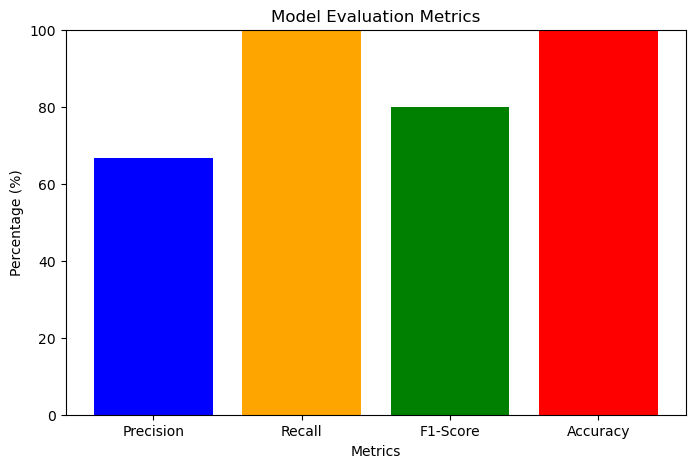

In [10]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt

# Assuming you have ground truth (gt) and predictions (pred) from the model
# gt: list of ground truth bounding boxes
# pred: list of predicted bounding boxes (with confidence scores)
# The boxes are in format [x1, y1, x2, y2]

# Dummy ground truth and predictions for illustration (replace with actual values)
ground_truth_boxes = [
    [50, 50, 150, 150],  # Example ground truth bounding box
    [200, 200, 300, 300]  # Another ground truth bounding box
]
predicted_boxes = [
    [55, 55, 145, 145],  # Predicted bounding box 1
    [195, 195, 295, 295],  # Predicted bounding box 2
    [400, 400, 500, 500]  # False positive (predicted bounding box)
]

# IoU function
def compute_iou(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    # Calculate intersection area
    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    # Calculate union area
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area > 0 else 0
    return iou

# Compute IoU for each predicted box
iou_threshold = 0.5
true_positives = 0
false_positives = 0
false_negatives = 0

for gt_box in ground_truth_boxes:
    matched = False
    for pred_box in predicted_boxes:
        iou = compute_iou(gt_box, pred_box)
        if iou >= iou_threshold:
            true_positives += 1
            matched = True
            break
    if not matched:
        false_negatives += 1

for pred_box in predicted_boxes:
    matched = False
    for gt_box in ground_truth_boxes:
        iou = compute_iou(gt_box, pred_box)
        if iou >= iou_threshold:
            matched = True
            break
    if not matched:
        false_positives += 1

# Precision, Recall, F1-Score
precision = (true_positives / (true_positives + false_positives)) * 100 if (true_positives + false_positives) > 0 else 0
recall = (true_positives / (true_positives + false_negatives)) * 100 if (true_positives + false_negatives) > 0 else 0
f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Accuracy Calculation (Percentage of correct detections)
accuracy = (true_positives / len(ground_truth_boxes)) * 100 if len(ground_truth_boxes) > 0 else 0

# Print Metrics
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-Score: {f1:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")  # Display as percentage

# FPS (Frames Per Second)
start_time = time.time()

# Simulate processing of 100 frames (replace with actual processing loop)
frame_count = 100
for _ in range(frame_count):
    # Replace this with actual model frame processing
    time.sleep(0.03)  # Simulating time taken per frame

end_time = time.time()
fps = frame_count / (end_time - start_time)

print(f"FPS: {fps:.2f}")

# Plot the metrics
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
values = [precision, recall, f1, accuracy]  # All metrics are now percentages

plt.figure(figsize=(8, 5))
plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 100)  # Set y-axis range to 100%
plt.xlabel('Metrics')
plt.ylabel('Percentage (%)')
plt.title('Model Evaluation Metrics')
plt.show()

# Optional: Mean Average Precision (mAP)
# This is a more complex evaluation metric, usually based on IoU thresholds across multiple frames.
